In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time as time
import gc
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif


In [23]:
path = os.getcwd()
data = path + '/dataset/bank/bank-additional/bank-additional-full.csv'
df_orig = pd.read_csv(data, sep=';')
print(f'size of the data --> {df_orig.shape}')
df_orig.head()

size of the data --> (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# create table listing column types etc
df = df_orig.copy()        # make a copy of the data before any transformations

df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'Duplicates dropped --> {df.duplicated().sum()}')
# drop duplicates, 12 rows
df = df.drop_duplicates()
df_info

Duplicates dropped --> 12


,column,dtype,NA_count,unique_count
0,age,int64,0,78
1,job,object,0,12
2,marital,object,0,4
3,education,object,0,8
4,default,object,0,3
5,housing,object,0,3
6,loan,object,0,3
7,contact,object,0,2
8,month,object,0,10
9,day_of_week,object,0,5


## Feature Selection

In [4]:
'''pipeline for preprocessing'''
# Drop response variable from the dataframe
y = df['y']
df = df.drop('y', axis=1)
X = df
# drop duration as it is not known before a call is performed
# df.drop('duration', axis=1)

# Create a pipeline for categorical features
cat_features = df.select_dtypes(include=['object']).columns
cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# df_cat= cat_pipeline.fit_transform(df[cat_features])

# Create a pipeline for numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Create a column transformer
preprocessor = ColumnTransformer([
        ('cat', cat_pipeline, cat_features),
        ('num', num_pipeline, num_features)
])

### Use K Best

Hard to use with encoded categorical data.

In [12]:
select = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(f_classif, k=14))
])

X_new = select.fit_transform(X, y)

best = select.fit(X, y)
best.get_feature_names_out()

array(['cat__contact_cellular', 'cat__contact_telephone',
       'cat__month_mar', 'cat__month_oct', 'cat__month_sep',
       'cat__poutcome_nonexistent', 'cat__poutcome_success',
       'num__duration', 'num__pdays', 'num__previous',
       'num__emp.var.rate', 'num__cons.price.idx', 'num__euribor3m',
       'num__nr.employed'], dtype=object)

Use with numerical to get an idea of feature importance.

In [17]:
# run select on just numerical features
X_num = X[num_features]
select_num = Pipeline([
        ('preprocessor', num_pipeline),
        ('selector', SelectKBest(f_classif, k=8))
])
best_num = select_num.fit(X_num, y)
print('features selected: ')
print(best_num.get_feature_names_out())
print('scores:{} '.format(best_num['selector'].scores_))
print('features rejected:')
print(X_num.columns[best_num['selector'].get_support() == False])

features selected: 
['duration' 'campaign' 'pdays' 'previous' 'emp.var.rate' 'cons.price.idx'
 'euribor3m' 'nr.employed']
scores:[  38.03776219 8092.86433112  182.12162486 4860.86431487 2304.02042926
 4021.29829691  777.46374246  124.0278517  4307.26454891 5924.52918989] 
features rejected:
Index(['age', 'cons.conf.idx'], dtype='object')


- Deal with 'unknowns' so data is less complex.
- Where unknowns are a very small percentage, we can impute them with the mode.
- Days of the week is one of the least "important" features o we can drop it.
- 

In [29]:
# impute unknowns with mode for marital, housing, loan, job, education
# remove illiterate from education
# remove day_of_the_week
df = df_orig.copy()
imp_mode = SimpleImputer(missing_values='unknown',strategy='most_frequent')
df['marital'] = imp_mode.fit_transform(df[['marital']])
df['housing'] = imp_mode.fit_transform(df[['housing']])
df['loan'] = imp_mode.fit_transform(df[['loan']])
df['job'] = imp_mode.fit_transform(df[['job']])
df['education'] = imp_mode.fit_transform(df[['education']])
df = df[df['education'] != 'illiterate']
df = df.drop(['day_of_week'], axis=1)

In [35]:
import param_grids
from param_grids import param_rf
param_rf

{'classifier__n_estimators': [100, 200, 300],
 'classifier__max_depth': [10, 20, 30],
 'classifier__min_samples_split': [2, 5, 10],
 'classifier__min_samples_leaf': [1, 2]}

In [30]:
from make_model import make_model
import param_grids

random_state = 42
folds = 5
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

y = df['y']
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)

clf_grid, clf_param = make_model(df, X_train, y_train, X_test, y_test, model, parameters, folds=folds)


pickle.dump(clf_grid, open(f'new_model_dt_{folds}.pkl', 'wb'))

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.9349793719580631
Training Time : 1.942 minutes
Test Score : 0.9295570634710786


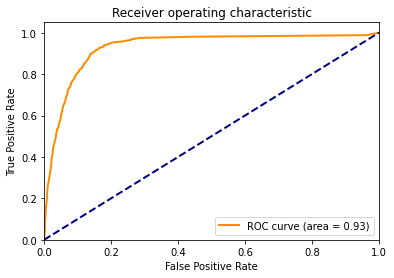

Accuracy:  0.9295570634710786


In [32]:
# load model
folds = 5
clf_grid = pickle.load(open(f'new_model_dt_{folds}.pkl', 'rb'))

# Convert string labels to binary values
le = LabelEncoder()
y_test = le.fit_transform(y_test)
y_prob = clf_grid.predict_proba(X_test)[:, 1]   # use predict_proba to get the probability scores for non-linear models
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

accuracy = clf_grid.score(X_test, y_test)
print('Accuracy: ', accuracy)